<center>
<img src="../imgs/ods_stickers.jpg">
    
## Открытый курс по машинному обучению
Автор материала: Data Scientist @ Zeptolab, лектор в Центре Математических Финансов МГУ Дмитрий Сергеев. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

In [3]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
# from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

# Эконометрический подход

### Стационарность

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как [**стационарность**](https://ru.wikipedia.org/wiki/Стационарность). 
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- Временной ряд справа не является стационарным, так как его матожидание со временем растёт

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Здесь не повезло с дисперсией - разброс значений ряда существенно варьируется в зависимости от периода

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Наконец, на последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределами учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

Чтобы бороться с нестационарностью, нужно узнать её в лицо, потому посмотрим, как её детектировать. Для этого обратимся к белому шуму и случайному блужданию, чтобы выяснить как попасть из одного в другое бесплатно и без смс.

График белого шума:

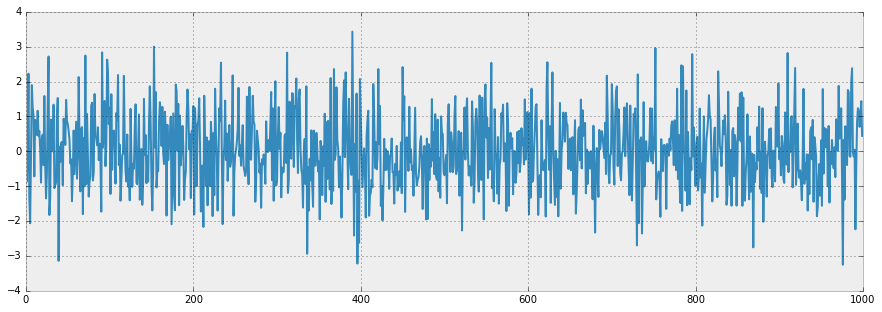

In [18]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля с отклонением в 1. Теперь на его основе сгенерируем новый процесс, в котором каждое последующее значение будет зависеть от предыдущего: $x_t = \rho x_{t-1} + e_t$ 

Код для отрисовки графиков

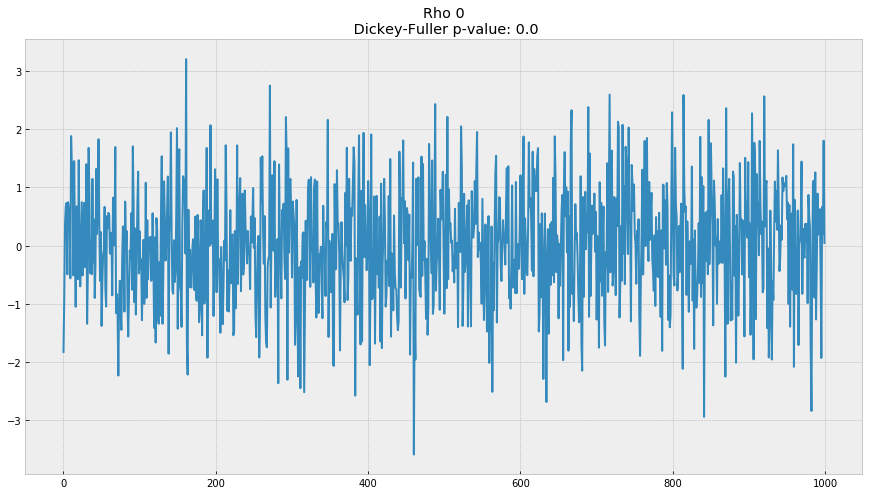

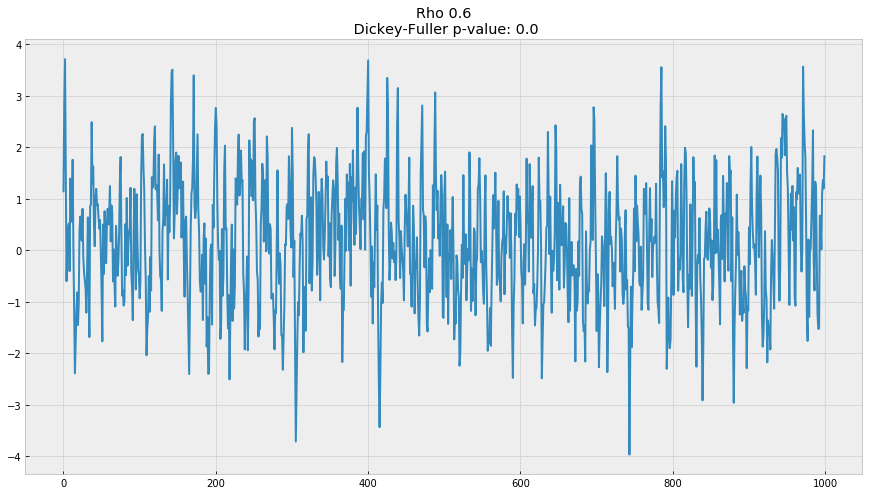

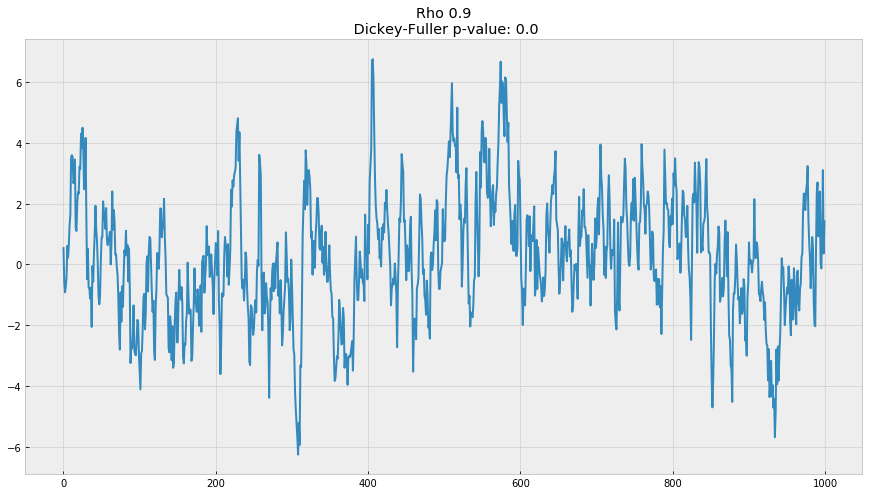

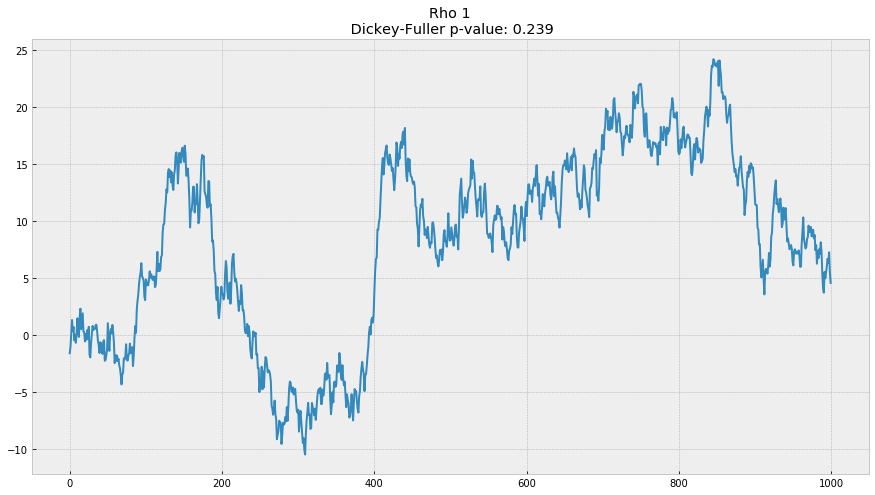

In [8]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(15, 8))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

На первом графике получился точно такой же стационарный белый шум, который строился раньше. На втором значение $\rho$ увеличилось до 0.6, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. Наконец, значение $\rho$ равное единице дало процесс случайного блуждания - ряд не стационарен.

Происходит это из-за того, что при достижении критической единицы, ряд $x_t = \rho x_{t-1} + e_t$ перестаёт возвращаться к своему среднему значению. Если вычесть из левой и правой части $x_{t-1}$, то получим $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, где выражение слева - первые разности. Если $\rho=1$, то первые разности дадут стационарный белый шум $e_t$. Этот факт лёг в основу теста [Дики-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера) на стационарность ряда (наличие единичного корня). Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка.
Нулевая гипотеза - ряд не стационарен, отвергалась на первых трех графиках, и принялась на последнем. Стоит сказать, что не всегда для получения стационарного ряда хватает первых разностей, так как процесс может быть интегрированным с более высоким порядком (иметь несколько единичных корней), для проверки таких случаев используют расширенный тест Дики-Фуллера, проверяющий сразу несколько лагов.

Бороться с нестационарностью можно множеством способов - разностями различного порядка, выделением тренда и сезонности, сглаживаниями и преобразованиями, например, Бокса-Кокса или логарифмированием.

## Избавляемся от нестационарности и строим SARIMA

Попробуем теперь построить ARIMA модель для онлайна игроков, пройдя все ~~круги ада~~ стадии приведения ряда к стационарному виду. Про саму модель уже не раз писали на хабре - [Построение модели SARIMA с помощью Python+R](https://habrahabr.ru/post/210530/), [Анализ временных рядов с помощью python](https://habrahabr.ru/post/207160/), поэтому подробно останавливаться на ней не буду.

Код для отрисовки графиков

In [59]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

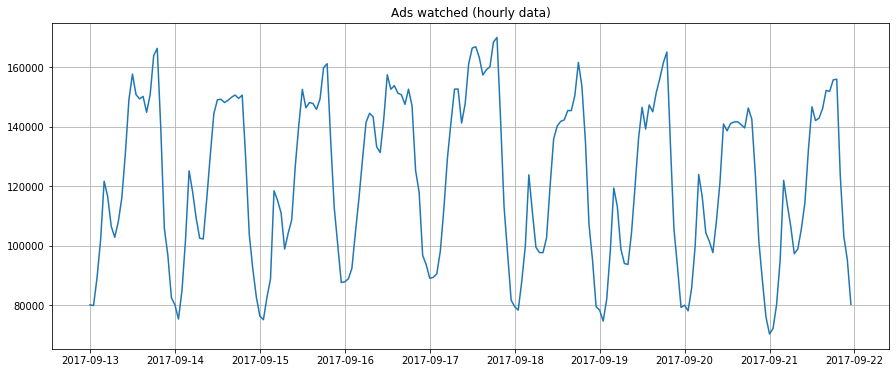

In [60]:
ads = pd.read_csv('../data/ads.csv', index_col=['Time'], 
                  parse_dates=['Time'])

plt.figure(figsize=(15, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

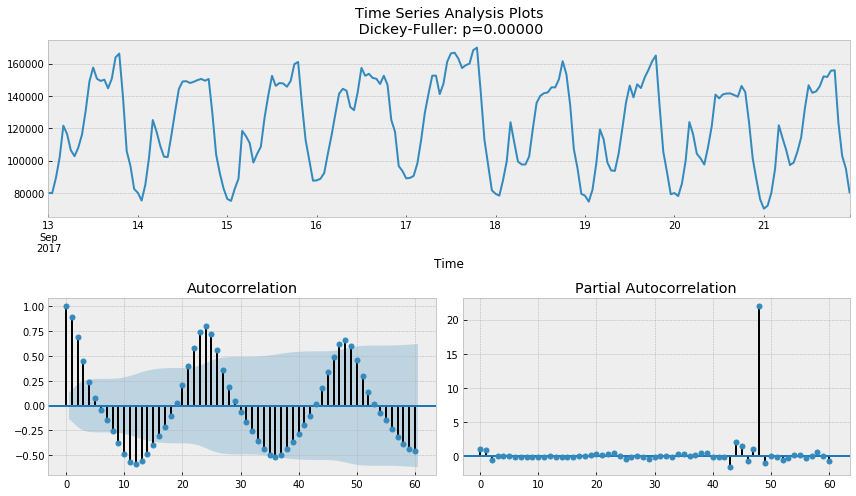

In [65]:
tsplot(ads.Ads, lags=60)

Удивительно, но критерий Дики-Фуллера отверг нулевую гипотезу о наличии единичного корня. Но автокорреляциоонные графики не выглядят так, будто они для стационарного ряда.

Да и мы знаем, что в данных есть суточная сезонность.

Для получения стационарности возьмем первые разности текущего момента и момента 24 часа назад.

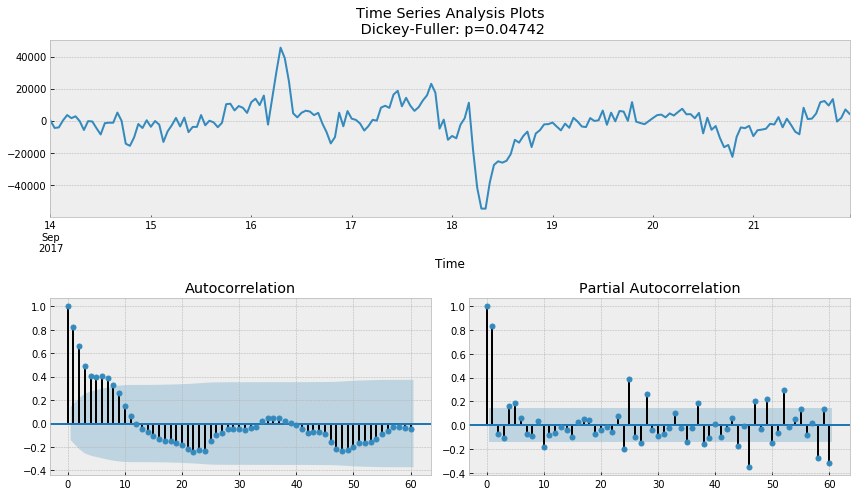

In [66]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

Уже лучше, однако автокорреляционная все еще не похожа на хорошую.

Возможно, в данных есть еще какая-то сезонность, но мы попробуем классический прием теперь - взять разности между текущим моментом и прошлым.

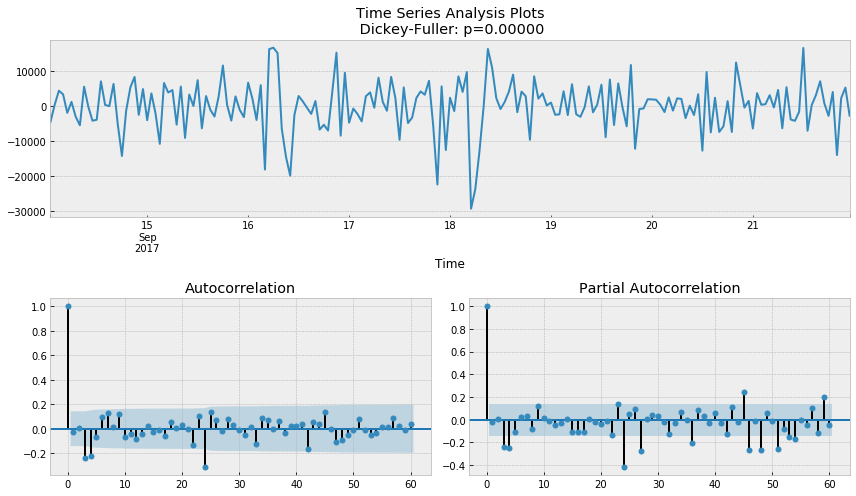

In [67]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Наконец, получили нужный стационарный ряд, пики автокорреляционных функций единичны.

Теперь можно строить модели

## ARIMA-family Crash-Course

$SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

- $AR(p)$ - авторегрессионная модель или регрессия временного ряда на самого себя. Основное предположение, что текущие значения ряда зависят от предыдущих с некоторым лагом. Наибольший лаг в такой модели обозначается параметром $p$. Чтобы найти параметр $p$, нужно посмотреть на график PACF и найти наибольшее значимое значение лага, после которого **большинство** остальных лагов становится незначимыми.
- $MA(q)$ - модель скользящего среднего. Без углубления в детали можно сказать так: эта модель моделирует ошибки временного ряда с предположением, что текущие ошибки зависят от предыдущих с каким-то лагом. Максимальный лаг обозначается $q$ и ищется на графике ACF по той же логике, что и $p$. 

$AR(p) + MA(q) = ARMA(p, q)$

Получилась Autoregressive–moving-average модель! Если ряд стационарный, то он может предсказываться уже этой моделью. Продолжим дальше.

- $I(d)$ - порядок интегрирования. Обозначает, сколько раз нужно взять разности между соседними числами, чтобы добиться стационарности (не путать с вычитанием сезонности). 

Теперь получилась модель $ARIMA$, которая способна моделирость нестационарные временные ряды без сезонной составляющей.

- $S(s)$ - отвечает за сезонность и равняется периоды сезонности временного ряда.

Задается тремя параметрами: $(P, D, Q)$

- $P$ - порядок авторегресии для сезонной компоненты модели, который может быть получен из графика PACF. Но нужно смотреть на количесвто значимых лагов, помноженных на длину периода. То есть если длина периода 24, то надо смотреть, сколько значимых лагов будет в моменты кратные 24: 24, 48 и тд. Если для примера с сезональностью 24 будут значимы лаги 24 и 48, то $P$ должен быть 2.

- $Q$ - такая же логика, но с использованием графика ACF.

- $D$ - порядок сезонального интегрирования. Может быть равно 1 или 0, в зависимости от того, была ли применена сезональная разность.

Начальные приближения для наших данных:

- $p$ скорее всего 4, так как это последний значимый лаг PACF, после которого остальные незначимые. 
- $d$ равно 1, так как для стационарности нам хватило первых разностей
- $q$ судя по графику ACF должно быть в районе 4
- $P$ должно быть 2, так как 24 и 48 лаги значимы на PACF
- $D$ должно равняться 1, так как мы применили сезональную разность
- $Q$ скорее всего 1. Так как 24 лаг на ACF еще значим, а 48 уже нет.

In [47]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [50]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in parameters_list:
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [51]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

CPU times: user 7min 33s, sys: 12.6 s, total: 7min 45s
Wall time: 2min 3s


In [52]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


Лучшие параметры загоняем в модель:

In [53]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -1936.321
Date:                            Mon, 11 Nov 2019   AIC                           3888.642
Time:                                    10:49:53   BIC                           3914.660
Sample:                                09-13-2017   HQIC                          3899.181
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.5503      0.306   

Let's inspect the residuals of the model.

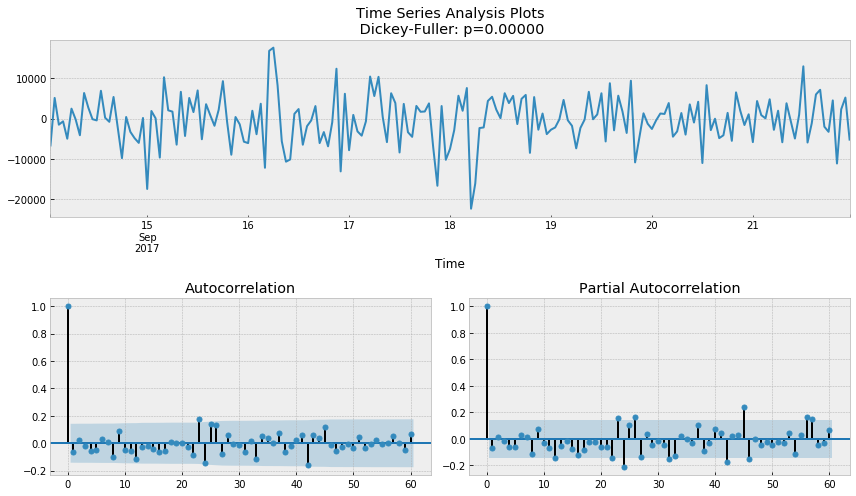

In [54]:
tsplot(best_model.resid[24+1:], lags=60)

Что ж, остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

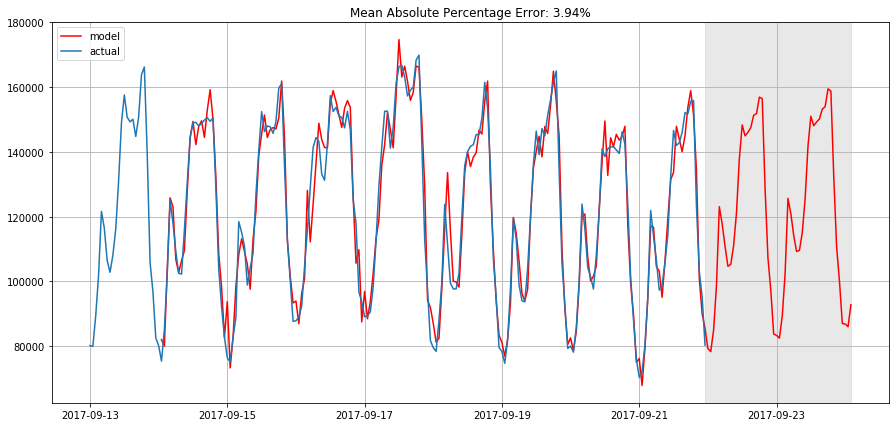

In [58]:
plotSARIMA(ads, best_model, 50)

# Полезные ресурсы

- [Онлайн учебник](https://people.duke.edu/~rnau/411home.htm) курса по продвинутому статистическому прогнозированию университета Duke - разобраны всевозможные сглаживания, линейные модели и ARIMA модели 
- Статья [Comparison of ARIMA and Random Forest time series models for prediction of avian influenza H5N1 outbreaks](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276) - одна из немногих, где активно защищается позиция случайного леса в задачах по прогнозированию временных рядов
- Статья [Time Series Analysis (TSA) in Python - Linear Models to GARCH](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016) семействе моделей ARIMA и их применении для моделирования финансовых показателей (Brian Christopher)